In [24]:
from numpy.random import Generator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.optimize import minimize 
from scipy.stats import gaussian_kde

In [25]:
try:
    plt.style.use('neuroblu')
except:
    print('neuroblu style not found. Using default style!')

In [26]:
config = {
    'nbase': 250,
    'neca': 1000,
}

In [27]:
def plot_dist(data1, data2, col, ax=None):
    if not ax:
        _, ax = plt.subplots(1,1)
        
    ax.hist(data1[col], density=True, fill='black', histtype='stepfilled', 
             edgecolor='black', linewidth=1.2, label=data1.name)
    ax.hist(data2[col], density=True, fill='blue', histtype='stepfilled',
             edgecolor='blue', linewidth=1.2, label=data2.name, alpha=0.7)
    ax.legend()
    ax.set_title(col)
    return 

In [28]:
# For Base cohort
age = 45
lab1 = 3.4
lab2 = 5000

mean = [age, lab1, lab2]
cov = [[14, 3, 100], 
       [3, 2, 50],
       [100, 50, 8000]]

# np.random.seed(0)
x = np.random.default_rng().multivariate_normal(mean, cov, config['nbase'])
x[x< 0] = 0

lab3 = np.random.beta(1, 2, size=config['nbase'])
x = np.concatenate((x, lab3.reshape(config['nbase'], -1)), axis=1)

data_base = pd.DataFrame(x, columns=['age', 'lab1', 'lab2', 'lab3'])

In [29]:
# For External cohort
age = 50
lab1 = 5.5
lab2 = 4900

mean = [age, lab1, lab2]
cov = [[20, 5, 150], 
       [5, 4, 100],
       [150, 100, 55000]]

x = np.random.default_rng().multivariate_normal(mean, cov, config['neca'])
x[x< 0] = 0

lab3 = 1.5*np.random.beta(1, 2, size=config['neca'])
x = np.concatenate((x, lab3.reshape(config['neca'], -1)), axis=1)

data_eca = pd.DataFrame(x, columns=['age', 'lab1', 'lab2', 'lab3'])

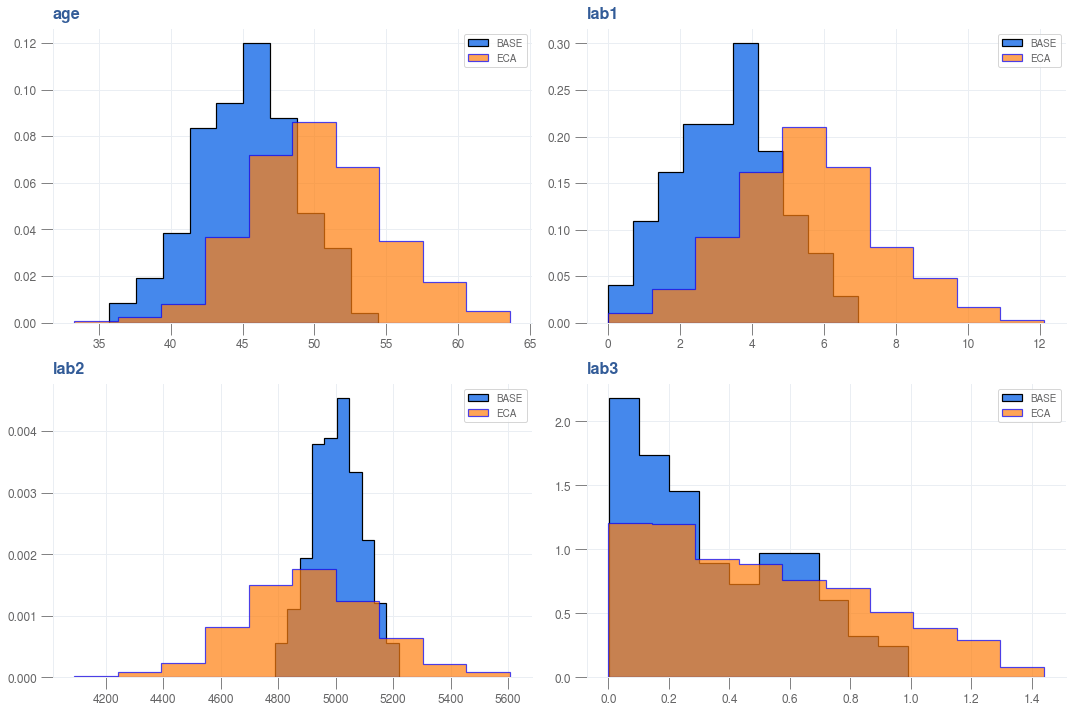

In [30]:
_, ax = plt.subplots(2,2, figsize=(15, 10))

data_base.name = 'BASE'
data_eca.name = 'ECA'
plot_dist(data_base, data_eca, 'age', ax[0][0])
plot_dist(data_base, data_eca, 'lab1', ax[0][1])
plot_dist(data_base, data_eca, 'lab2', ax[1][0])
plot_dist(data_base, data_eca, 'lab3', ax[1][1])

In [31]:
density_age = gaussian_kde(data_base['age'])
density_lab1 = gaussian_kde(data_base['lab1'])
density_lab2 = gaussian_kde(data_base['lab2'])
density_lab3 = gaussian_kde(data_base['lab3'])

In [32]:
b = max(data_base['age'].max(), data_eca['age'].max())
a = min(data_base['age'].min(), data_eca['age'].min())
waypoints_age = np.linspace(a, b, 100)

b = max(data_base['lab1'].max(), data_eca['lab1'].max())
a = min(data_base['lab1'].min(), data_eca['lab1'].min())
waypoints_lab1 = np.linspace(a, b, 100)

b = max(data_base['lab2'].max(), data_eca['lab2'].max())
a = min(data_base['lab2'].min(), data_eca['lab2'].min())
waypoints_lab2 = np.linspace(a, b, 100)

b = max(data_base['lab3'].max(), data_eca['lab3'].max())
a = min(data_base['lab3'].min(), data_eca['lab3'].min())
waypoints_lab3 = np.linspace(a, b, 100)

In [33]:
kde_age = density_age(waypoints_age)
kde_lab1 = density_age(waypoints_lab1)
kde_lab2 = density_age(waypoints_lab2)
kde_lab3 = density_age(waypoints_lab3)

In [34]:
def calc_loss(w):    
    est_den_age = gaussian_kde(data_eca['age'], weights=w)
    est_den_lab1 = gaussian_kde(data_eca['lab1'], weights=w)
    est_den_lab2 = gaussian_kde(data_eca['lab2'], weights=w)
    est_den_lab3 = gaussian_kde(data_eca['lab3'], weights=w)
    
    loss = (density_age(waypoints_age)- est_den_age(waypoints_age))**2 + \
    (density_age(waypoints_lab1)- est_den_lab1(waypoints_lab1))**2 + \
    (density_age(waypoints_lab2)- est_den_lab2(waypoints_lab2))**2 + \
    (density_age(waypoints_lab3)- est_den_lab3(waypoints_lab3))**2
        
    return sum(loss)

In [43]:
cons = ({'type': 'ineq', 'fun': lambda x:  x - 0.0001},
        {'type': 'eq', 'fun': lambda x: sum(x) - 1})

In [44]:
%%time
weights = np.ones(config['neca'])/config['neca']

bounds = list(zip(np.zeros(config['neca']), np.ones(config['neca'])))
wopt = minimize(calc_loss, weights, constraints=cons, options= 
            {"disp":True,"maxiter":1000})
p = wopt.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: 12.006512048819408
            Iterations: 6
            Function evaluations: 6006
            Gradient evaluations: 6
CPU times: user 1min 9s, sys: 191 ms, total: 1min 9s
Wall time: 1min 9s


In [45]:
wopt.success

True

In [46]:
data_eca_study = data_eca.sample(n=config['nbase'], replace=True, weights=p, 
                                 random_state=100)
data_eca_study.name = 'ECA'

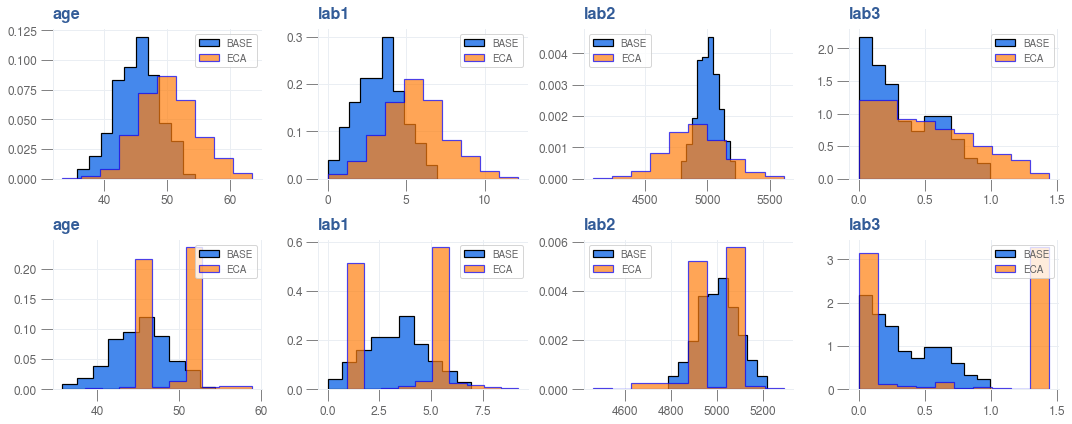

In [47]:
_, ax = plt.subplots(2,4, figsize=(15, 6))

plot_dist(data_base, data_eca, 'age', ax[0][0])
plot_dist(data_base, data_eca, 'lab1', ax[0][1])
plot_dist(data_base, data_eca, 'lab2', ax[0][2])
plot_dist(data_base, data_eca, 'lab3', ax[0][3])

plot_dist(data_base, data_eca_study, 'age', ax[1][0])
plot_dist(data_base, data_eca_study, 'lab1', ax[1][1])
plot_dist(data_base, data_eca_study, 'lab2', ax[1][2])
plot_dist(data_base, data_eca_study, 'lab3', ax[1][3])

In [48]:
from scipy.stats import ks_2samp

In [49]:
for col in data_base.columns:
    print(f'Distribution of {col}')
    print('Before balancing', ks_2samp(data_base[col], data_eca[col]))
    print('After balancing', ks_2samp(data_base[col], data_eca_study[col]))
    print('\n')

Distribution of age
Before balancing KstestResult(statistic=0.461, pvalue=2.0412716756053056e-39)
After balancing KstestResult(statistic=0.576, pvalue=1.1233017298027725e-38)


Distribution of lab1
Before balancing KstestResult(statistic=0.497, pvalue=3.619586645038567e-46)
After balancing KstestResult(statistic=0.448, pvalue=5.804854715774574e-23)


Distribution of lab2
Before balancing KstestResult(statistic=0.386, pvalue=2.5065733113957977e-27)
After balancing KstestResult(statistic=0.392, pvalue=1.5754625913309287e-17)


Distribution of lab3
Before balancing KstestResult(statistic=0.192, pvalue=6.706482418294968e-07)
After balancing KstestResult(statistic=0.476, pvalue=5.388549143906695e-26)


